In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import statsmodels.api as sm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Logistic Regression Review
Please complete these series of exercises within your groups.

1) Create a logistic regression model based on the data below.

2) Determine which predictors are significant. (Use sm.logit() and p<0.1)

3) Split Test/Train and re-run the model now that you have chosen only significant variables. (Use SKLearn's LogisticRegression). Find test accuracy.

4) Figure out what your best value for $C=\frac{1}{\lambda}$ is. (Test at least 4 values)

5) Re-run the model for this tuned hyperparameter.

6) Create a holdout dataset.

7) Find the holdout accuracy

8) Find the 5-fold cross-validation on the non-holdout data (using cross_val_score)

9) Create a confusion matrix for this new model.

10) Plot your ROC curve.

In [11]:
#Data Generation
Xs, y = datasets.make_classification(n_features=5,n_informative=3,n_redundant=0)

In [12]:
#1)
logit = sm.Logit(y,Xs)

In [13]:
#2)
logit.fit().summary() #Significant Predictors: X2, X3, X5

Optimization terminated successfully.
         Current function value: 0.446812
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       95
Method:                           MLE   Df Model:                            4
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:                  0.3554
Time:                        18:33:57   Log-Likelihood:                -44.681
converged:                       True   LL-Null:                       -69.315
                                        LLR p-value:                 5.136e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3911      0.281     -1.391      0.164      -0.942       0.160
x2            -1.1593      0.288     -4.026      0.000      -1.724      -0.595
x3             1.0126      0.253      4.002      0.000       0.517       1.509
x4             0.5399      0.331      1.631      0.103      -0.109       1.188
x5             0.5883      0.188      3.126      0.002       0.219       0.957
==============================================================================
"""

In [24]:
#3)
Xs = pd.DataFrame(Xs)
sigxs = pd.DataFrame(Xs).iloc[:,[1,2,4]]

X_train, X_test, y_train, y_test = train_test_split(sigxs, y, test_size=0.2)

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train,y_train)
print(logreg.score(X_test,y_test))

0.85


In [32]:
#4)
model = LogisticRegression(solver='lbfgs')
grid = {'C':[0.01,0.1,1,10,100]}

gscv = GridSearchCV(model,grid,verbose=True,return_train_score=False,cv=10)
gscv.fit(sigxs,y)

scores = pd.DataFrame(gscv.cv_results_).filter(regex='param_+|mean_test_score'
                                            ).sort_values('mean_test_score',
                                                          ascending=False).reset_index().drop(['index'],axis=1)
scores

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


,param_C,mean_test_score
0,1,0.79
1,10,0.79
2,100,0.79
3,0.1,0.78
4,0.01,0.74


In [35]:
model = LogisticRegression(solver='lbfgs',C=1)
model.fit(X_train,y_train)
print(model.score(X_test,y_test))

0.85


In [36]:
X_train, X_ho, y_train, y_ho = train_test_split(sigxs, y, test_size=0.2)
print(cross_val_score(logreg,X_train,y_train,cv=10).mean())
model = LogisticRegression(solver='lbfgs',C=1)
model.fit(X_train,y_train)

0.8015873015873016


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [37]:
print(model.score(X_ho,y_ho))

0.75


In [38]:
print(metrics.confusion_matrix(y_ho,logreg.predict(X_ho)).transpose())

[[ 5  2]
 [ 3 10]]


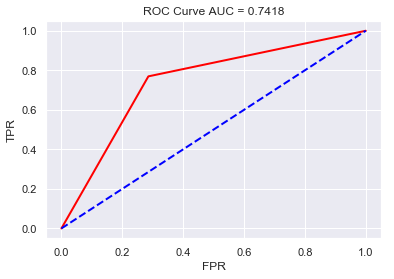

In [39]:
model = LogisticRegression(solver='lbfgs',C=1)
model.fit(X_train,y_train)
aucscore = metrics.roc_auc_score(logreg.predict(X_ho),y_ho)

##Computing false and true positive rates
fpr, tpr,_= metrics.roc_curve(logreg.predict(X_ho),y_ho,drop_intermediate=False)

##Adding the ROC
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve AUC = '+str(aucscore.round(4)))
plt.show()